This notebook assumes sims_maf version >= 1.1 and that you have 'setup sims_maf' in your shell. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

##Writing a new metric##

MAF provides many 'stock' metrics, and there are more in the sims_maf_contrib library. 

In [2]:
# List of provided metrics
metrics.BaseMetric.list(doc=False)

AveSlewFracMetric
BinaryMetric
Coaddm5Metric
CompletenessMetric
CountMetric
CountRatioMetric
CountSubsetMetric
CountUniqueMetric
ExgalM5
FftMetric
FilterColorsMetric
FracAboveMetric
FracBelowMetric
FullRangeAngleMetric
FullRangeMetric
HourglassMetric
IdentityMetric
LinkedMetric
LongGapAGNMetric
MaxMetric
MaxPercentMetric
MaxStateChangesWithinMetric
MeanAngleMetric
MeanMetric
MedianAbsMetric
MedianMetric
MinMetric
MinTimeBetweenStatesMetric
NChangesMetric
NRevisitsMetric
NStateChangesFasterThanMetric
NormalizeMetric
NoutliersNsigmaMetric
OpenShutterFractionMetric
ParallaxMetric
PercentileMetric
ProperMotionMetric
RadiusObsMetric
RapidRevisitMetric
RmsAngleMetric
RmsMetric
RobustRmsMetric
SlewContributionMetric
SumMetric
SupernovaMetric
TableFractionMetric
TeffMetric
TemplateExistsMetric
TgapsMetric
TotalPowerMetric
TransientMetric
UniformityMetric
VisitGroupsMetric
ZeropointMetric
fOArea
fONv


But at some point, you're likely to want to write your own metric. We have tried to make the process for this simple. 

Here is the code for a very simple, (existing) metric which calculates the coadded depth of a set of visits. 

In [3]:
from lsst.sims.maf.metrics import BaseMetric

class Coaddm5Metric(BaseMetric):
    """Calculate the coadded m5 value at this gridpoint."""
    def __init__(self, m5Col = 'fiveSigmaDepth', metricName='CoaddM5', **kwargs):
        """Instantiate metric.
        m5col = the column name of the individual visit m5 data."""
        self.m5col = m5col
        super(Coaddm5Metric, self).__init__(col=m5Col, metricName=metricName, **kwargs)
    def run(self, dataSlice, slicePoint=None):
        return 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.m5col])))

To understand this, you need to know a little bit about "classes" and "inheritance". 

Basically, a "class" is a python object which can hold data and methods (like functions) to manipulate that data. The idea is that a class can be a self-encapsulated thing -- the class knows what its data should look like, and then the methods know how to work with that data.  

"Inheritance" means that you can create a child version of another class, that inherits all of its features - and possibly adds new data or methods or replaces data or methods of the parent. 

The point here is that the "framework" part of MAF is encapsulated in the BaseMetric. By inheriting from the BaseMetric (that's the bit where we said class Coaddm5Metric(**BaseMetric**) above), we get the column tracking so that MAF knows what columns to query the database for and we get added to the registry of existing metrics. 

By following the same API (the 'signature' of the methods), we can write a new metric that will plug into the MAF framework seamlessly. This means you write an `__init__` method that includes `(self,  **kwargs)` and whatever else your particular metric needs. And then you write a `run` method that is called as `run(self, dataSlice, slicePoint=None)`.  

`dataSlice` refers to the visits handed to the metric by the slicer. `slicePoint` refers to the metadata about the slice (such as it's ra/dec in the case of a HealpixSlicer, or it's bin information in the case of a OneDSlicer).

Let's write another example, this time to calculate the Percentile value of a given column in a set of visits.

In [4]:
# Import BaseMetric, or have it available to inherit from
from lsst.sims.maf.metrics import BaseMetric

# Define our class, inheriting from BaseMetric
class OurPercentileMetric(BaseMetric):
    # Add a doc string to describe the metric.
    """
    Calculate the percentile value of a data column
    """
    # Add our "__init__" method to instantiate the class.
    # We will make the 'percentile' value an additional value to be set by the user.
    # **kwargs allows additional values to be passed to the BaseMetric that you 
    #     may not have been using here and don't want to bother with. 
    def __init__(self, colname, percentile, **kwargs):
        # Set the values we want to keep for our class.
        self.colname = colname
        self.percentile = percentile
        # Now we have to call the BaseMetric's __init__ method, to get the "framework" part set up.
        # We currently do this using 'super', which just calls BaseMetric's method.
        # The call to super just basically looks like this .. you must pass the columns you need, and the kwargs.
        super(OurPercentileMetric, self).__init__(col=colname, **kwargs)
        
    # Now write out "run" method, the part that does the metric calculation.
    def run(self, dataSlice, slicePoint=None):
        # for this calculation, I'll just call numpy's percentile function.
        result = np.percentile(dataSlice[self.colname], self.percentile)
        return result

So then how do we use this new metric? Just as before, although you may have to adjust the namespace.

In [5]:
metric = OurPercentileMetric('airmass', 20)
slicer = slicers.HealpixSlicer(nside=64)
sqlconstraint = 'filter = "r" and night<365'
myBundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [6]:
opsdb = db.OpsimDatabase('enigma_1189_sqlite.db')
bgroup = metricBundles.MetricBundleGroup({0: myBundle}, opsdb, outDir='newmetric_test', resultsDb=None)
bgroup.runAll()

Querying database with constraint filter = "r" and night<365
Found 37613 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3738: SAWarning: Textual SQL expression 'filter = "r" and night<36...' should be explicitly declared as text('filter = "r" and night<36...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


Plotting.
monopole: 1.27666  dipole: lon: 120.219, lat: 58.6505, amp: 0.177193
Plotting complete.


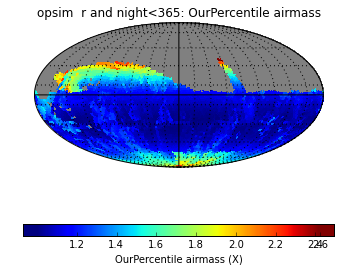

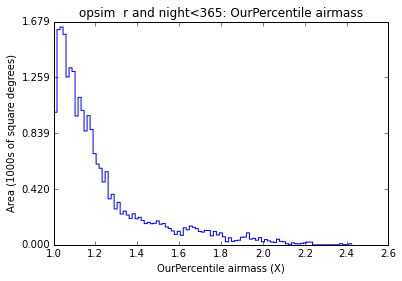

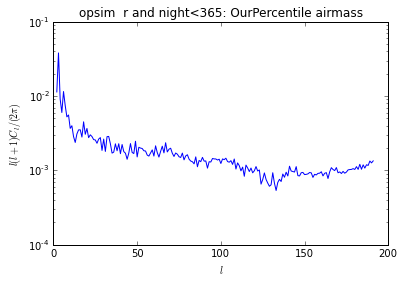

In [7]:
bgroup.plotAll(closefigs=False)